In order to successfully complete this assignment you must follow all instructions in this notebook and upload your files with your answers on or before **11:59pm on Friday March 1st**.

# Homework 4: Image Processing

In this assignment, you are going to modify and improve the processing speed of an edge detector for grayscale PNG images. Edge detection is an image processing technique to find boundaries of objects in images. Here are an example image and the detected edges:

**Note:** this homework was motivated and adapted from: https://web.stanford.edu/class/cs315b/assignment1.html

<table>
    <tr><td>
<img src="https://lh3.googleusercontent.com/KAUNwCSj6OGz-XCnH8vtA0zoxtiWhlw67IYzULXvfH37ap5JYz46i8TMU-mM4x7-dkOuc3hgUA=w740"></td><td><img src="https://lh4.googleusercontent.com/goBSqfFUUXwKaeVBJEm3zdwzQZLokNZBTEbDx8GE-axIB3EaLURys7bcFhPT89r2CKN0e87BHQ=w740"></td></tr>

The files necessary for this assignment are found in the following directory of the class git repository:

    HW4_Edge_Detection

&#9989; <font color=red>**DO THIS:**</font> Download the directory to your HPCC account and compile the software.  Note, this program uses the libpng library which is already installed on the HPCC. 


### Goals for this assignment:

By the end of this assignment, you should be able to:

* Debug and benchmark existing workflows.
* Using OpenMP to run code in parallel.
* Practice your technical communication skills though writing. 


# Code Description and Background 

There are lots of edge detection algorithms but in this assignment, you will work on an algorithm with the following three steps:

1. Image Smoothing
2. Gradient calculation (Sobel Filters)
3. Edge Thresholding

The following section describes each step in detail.

### Step 1: Smoothing (Average vs Median Filtering)
Before starting the actual edge detection, we smooth the image to reduce undesired edges detected due to noise. There are lots of ways to smooth an image. The code provided uses an Average Filter.  Average Filtering approaches uses a "sliding window algorithm".  The input and outputs of a "sliding window algorithm" is an image.  The value of each pixel in the output image is calculated using a "window" of data around the corresponding pixel in the input image.  

For the **Average Filter**, all of the pixels in the window for are averaged and the value is stored in the output image at the same location as the center pixel. 

If you think about it, the sliding window is not fully defined at the edges.  For the Average Filter this is not a problem. The algorithm just takes the media or average of the valid points within the windows. Here is a snip-it from the code:

```C++
//Average Filter 
for(int c=0;c<sz.width;c++) 
    for(int r=0;r<sz.height;r++)
    {
        double count = 0;
        double tot = 0;
        for(int cw=max(0,c-halfwindow); cw<min(sz.width,c+halfwindow+1); cw++)
            for(int rw=max(0,r-halfwindow); rw<min(sz.height,r+halfwindow+1); rw++)
            {
                count++;
                tot += (double) img[rw][cw];
            }
        output[r][c] = (int) (tot/count);
    }

```

### Step 2: Gradient calculation (Sobel Filter)

Assuming that each object consists of pixels that do not greatly vary in their brightness, the edges in an image are from the sudden changes of brightness in the pixels.  One way to measure how big the change is to calculate the gradient magnitude at each pixel. The gradient operator we are going to use in this assignment is Sobel operator. Sobel operator is based on the following two 3x3 filters, which calculate x and y component of the gradient, respectively:

$$ G_x =
\left[
\begin{matrix}
    -1   & 0 & 1  \\
    -2   & 0 & 2  \\
    -1   & 0 & 1 
 \end{matrix}
 \right]
 G_y = 
\left[
\begin{matrix}
    1   & 2 & 1  \\
    0   & 0 & 0  \\
    -1 & -2 & -1 
 \end{matrix}
 \right]
$$

Here is a code snip-it that creates the filters:

```c++
//Sobel Filters
double xfilter[3][3];
double yfilter[3][3];
xfilter[0][0] = -1;
xfilter[1][0] = -2;
xfilter[2][0] = -1;
xfilter[0][1] = 0;
xfilter[1][1] = 0;
xfilter[2][1] = 0;
xfilter[0][2] = 1;
xfilter[1][2] = 2;
xfilter[2][2] = 1;
for(int i=0;i<3;i++) 
    for(int j=0;j<3;j++)
        yfilter[j][i] = xfilter[i][j];

```

Once x and y components of the gradient is computed, the magnitude can be computed by: 

$$IMG_{Gradient} = \sqrt{G_x^2 + G_y^2}$$



```C++
// Gradient Filter
for(int c=1;c<sz.width-1;c++)
    for(int r=1;r<sz.height-1;r++)
        {
                double Gx = 0;
                double Gy = 0;
                for(int cw=0; cw<3; cw++)
                    for(int rw=0; rw<3; rw++)
                        {
                                Gx +=  ((double) output[r+rw-1][c+cw-1])*xfilter[rw][cw];
                                Gy +=  ((double) output[r+rw-1][c+cw-1])*yfilter[rw][cw];
                        }
                g_img[r][c] = sqrt(Gx*Gx+Gy*Gy);
        }
```

### Step 3: Edge Thresholding

The last step in the code provided is edge thresholding.  In this case, edges are defined based on the gradient image ($IMG_{Gradient}$).  Values over the threshold are considered edges and vales under the threshold are not edges.

$$IMG_{Edge} = IMG_{Gradient} > thresh$$

The threshold (```thresh```) may be varied to get different results.  For the images provided set the threshold to be 50. 


```C++
// Thresholding
for(int c=0;c<sz.width;c++)
    for(int r=0;r<sz.height;r++)
    if (g_img[r][c] > thresh)
        output[r][c] = 255;
    else
        output[r][c] = 0;
```

# HW4 Assignment

For this assignment you will do the following parts:

1. Establish Serial Benchmark
2. Optimize the Serial Code
3. Modify the code to use OpenMP loops
4. Final Report
5. Deliverables

## Part 1: Establish Serial Benchmark

&#9989; <font color=red>**DO THIS:**</font> Benchmark the code provided using the image files provided in the images directory.  This file should provide a solid baseline.  Make sure your results account for hardware and system variation on the dev-intel18 node. 

## Part 2: Optimize the Serial Code
The code provided does not optimized very well.  There are lots of things that could be done to speed up the existing code. For this homework I would like you try and benchmark two optimizations:

1. Use different levels of compiler optimization 
1. Change the order of the loops (row and column) for the Average Filter, Gradient Filter and Edge Thresholding. See if the change in order will increase speed due to multiple cache hits. 

&#9989; <font color=red>**DO THIS:**</font> Make the updates to the serial code as described above.  Benchmark and compare the time differences between the original version, the modified versions.  Pick the changes that provide for the fastest code.  Make all comparisons on the dev-intel18 node.

Make sure you also save a version of your best serial code to turn in. 

## Part 3: Modify the code to use OpenMP loops

&#9989; <font color=red>**DO THIS:**</font> Rewrite the code to use OpenMP loops to run the Average Filter, Gradient Filter and Edge Thresholding in parallel.  Make sure you carefully note the types of changes you make and use proper synchronization.  Benchmark your changes with different OMP Loop Scheduling options and compare to the serial benchmarks.

### OMP Loop Scheduling Options
Watch the following video which talks about ways to play around with schedulign options:

* &#9989; <font color=red>**DO THIS:**</font> Scheduling [Introduction to OpenMP: 10 Discussion 4](https://www.youtube.com/watch?v=8jzHiYo49G0)  

>**schedule(static [,chunk])** Deal-out blocks of interations of size "chunk" to each thread
> 
>**schedule(dynamic[,chunk])** Each thread grabs "chunk" Iterations off a queue until all iterations have been handeled.
> 
>**schedule(guided[,chunk])** Threads dynamically grab blocks of iterations. The size of the block starts large and shrinks down to size "chnunk" as the calculation proceeds.
> 
>**schedule(runtime)** Schedule and chunk size taken from OMP_SCHEDULE enviornment variable (or the runtime library).
> 
>**schedule(auto)** Schedule is left up to the runtime to choose (does not have to be any of the above).


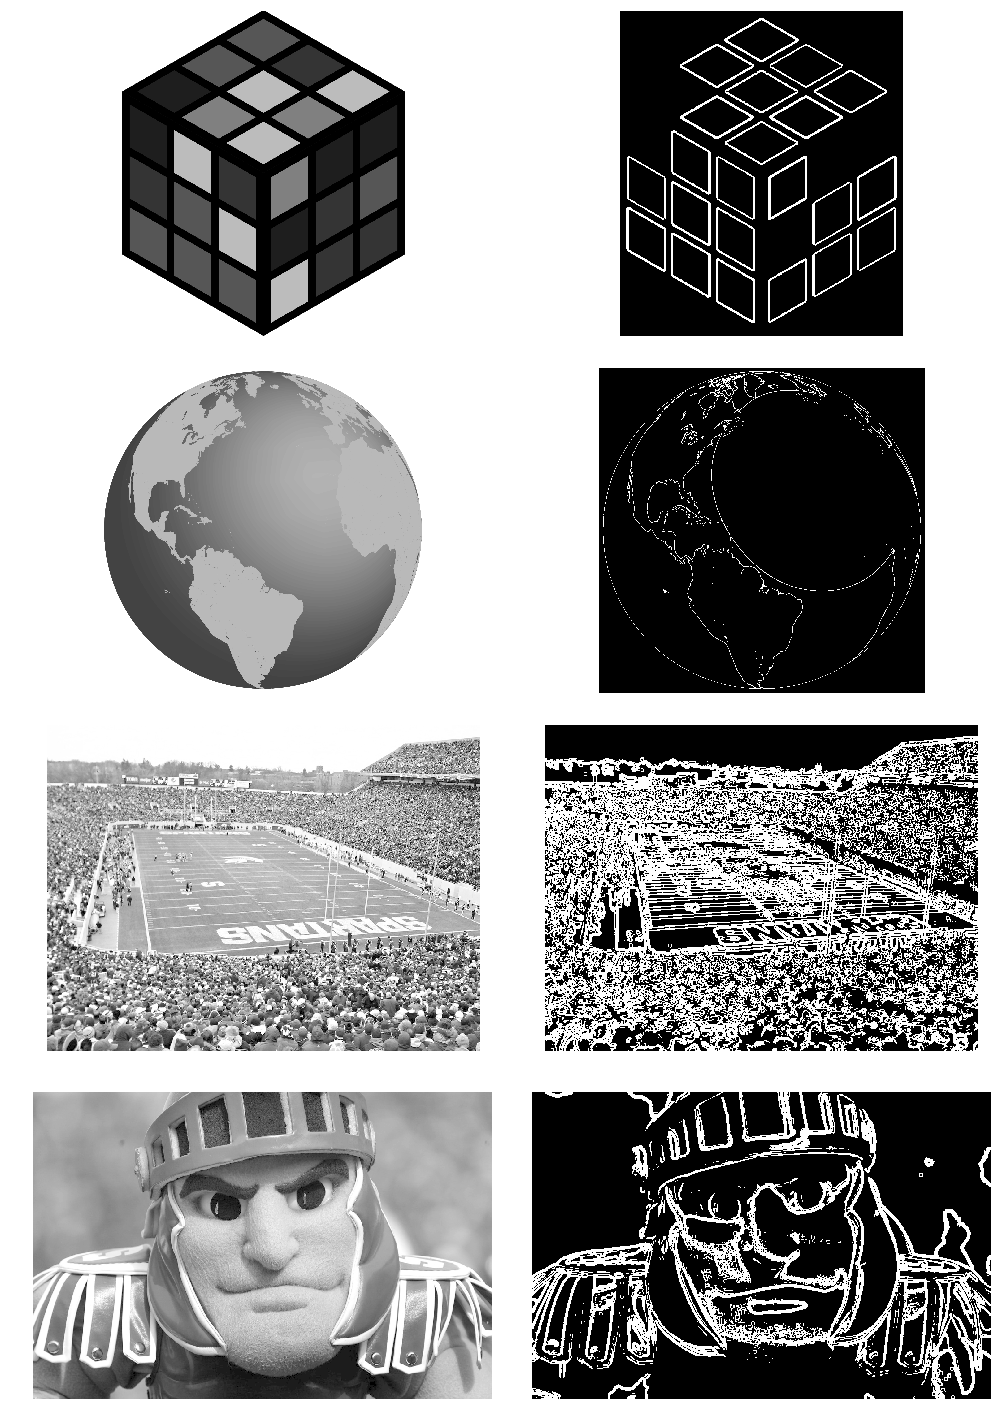

In [32]:
# Code for loading png images in python
# feel free to load two different version of an edge file, subtract them and compare the difference
# This can be very good when you try to debug. 
%matplotlib inline
import matplotlib.pylab as plt
import imageio

# filename = 'HW4_Edge_Detection/images/sparty.png'

# im = imageio.imread(filename)
    
# #Show the image
# plt.imshow(im, cmap='gray');
# plt.axis('off');
im1 = imageio.imread('HW4_Edge_Detection/images/cube.png')
im3 = imageio.imread('HW4_Edge_Detection/images/earth.png')
im5 = imageio.imread('HW4_Edge_Detection/images/MSUStadium.png')
im7 = imageio.imread('HW4_Edge_Detection/images/sparty.png')
im2 = imageio.imread('1.png')
im4 = imageio.imread('2.png')
im6 = imageio.imread('3.png')
im8 = imageio.imread('4.png')
fig=plt.figure(figsize=(14,20))
ax1=fig.add_subplot(421)
ax1.imshow(im1, cmap='gray');
ax1.axis("off")
ax2=fig.add_subplot(422)
ax2.imshow(im2, cmap='gray');
ax2.axis("off")
ax3=fig.add_subplot(423)
ax3.imshow(im3, cmap='gray');
ax3.axis("off")
ax4=fig.add_subplot(424)
ax4.imshow(im4, cmap='gray');
ax4.axis("off")
ax5=fig.add_subplot(425)
ax5.imshow(im5, cmap='gray');
ax5.axis("off")
ax6=fig.add_subplot(426)
ax6.imshow(im6, cmap='gray');
ax6.axis("off")
ax7=fig.add_subplot(427)
ax7.imshow(im7, cmap='gray');
ax7.axis("off")
ax8=fig.add_subplot(428)
ax8.imshow(im8, cmap='gray');
ax8.axis("off")
plt.tight_layout()

In [33]:
# | Image  | Original | Reordered Serial | Optimized Serial | OMP Static |OMP Dynamic|OMP Guided|OMP Auto| 
# |-------|-------|---------|-----------------|-|-|-|-|
# |  Cube   |0.1910956|0.182829 |0.0582486|0.0876378 |0.2964312 |0.0826074|0.1028786|
# | Earth   |6.8565736|5.595701 |1.7506926|0.6301746 |5.613174 |0.6546896 | 0.6453644 |
# | Stadium |0.2635264|0.244183 |0.104861|0.1036822 |0.4339698| 0.1206008|0.1128932 |
# | Sparty  |0.2029088|0.1887242|0.0678246|0.0834626 |0.2214036 | 0.130867| 0.0912596|

| Image  | Original | Reordered_Serial | Optimized Serial | OMP Static |OMP Dynamic|OMP Guided|OMP Auto| 
|-------|-------|---------|-----------------|-|-|-|-|
|  Cube   |0.191|0.183 |0.0582|0.0876 |0.296 |0.0826|0.103|
| Earth   |6.857|5.596 |1.751|0.630 |5.613 |0.655 | 0.645 |
| Stadium |0.264|0.244 |0.105|0.104 |0.434| 0.121|0.113 |
| Sparty  |0.203|0.189|0.0678|0.0835 |0.221 | 0.131| 0.0913|

## Part 4: Final Report


The provided serial code ran decently well as is, provided one was only doing a couple of images. For higher resolution images, it came close to 7 seconds per image on the dev-intel18 processors. If one wanted to do the edge detection on thousands of images, this would fail as a method. Its too slow for too little payout. I should elaborate that I recorded all my times by using omp_get_wtime() in the main function of the code, and ran the code 5 times, recording the average value. 

If one wants to optimize there serial code, there a quite a few ways to do it. The easiest and simplest are changing the order of for loops and compiler optimiaztion. Depending on the images you use, one can speed up the code by switching the order in which rows and columns are called. This is due to memory restrictions involving the cache, but if you are processing a lot of images with the same resolution, it may be worth while to switch them around yourself and see if you get improvement. Compiler Optimization is almost always worth checking out however, as the speed up from it can be extraordinary, and it requires very little work to implement.

But this code lends itslef extremely well to parallelization, and I was able to heavilly parallize it using only 3 lines of code.

After the comments for Average Filter, Gradient Filter and Edge Thresholding, I added the line  

#pragma omp parallel for collapse(2) schedule(runtime)

which parallizes the outer two loops, while collapsing them into each other.

Because the images were not an extremely resolution and the work done was minimal, static, followed by guided and auto, were the best scheduling options. Dynamic fell very far behind these three. I called for the default number of cores, which would be 40 cores, and the significant number of cores, and small workload, are likely what caused dynamic to run so poorly, though this is just speculation on my part based off an admittedly small sample.  

Provided above are before and after images of the provided 4 images, and a table with all the timing data. I considered creating a plot, but couldn't decide on the best way to present it meaningfully with a plot, as I didn't conduct anything linear like a scale study. I felt that the table was the best way to present the data considering that the "x direction" has no set order, and there were not many timings per image.

 - Depending on the problem, OpenMP can be implemented very easily, with significant improvements in speed provided. However, it does depend on a working knowledge of the variable space, which can sometimes be asking a lot.
 - The speed up from compiler optimization can approach the speeds of parallized code. Always check them if speed is a concern.
 - It is also worthwhile to check the different scheduling options, depending on the number of tasks and how heavy they are, different scheduling options will provide better results. Check them.

### Grayscale PNG images
The code provided is desinged to work only with grayscale ```*.png```  images. Most PNG images are color and many images are in different formats (ex. TIFF, jpeg).  Fortunatly there is an easy to use command called ```convert``` which comes with the [ImageMagick](https://www.imagemagick.org/) Library. Feel free to download and install the software for your own use or use the software already installed on the HPCC.  The following examples can be used on the HPCC to load ImageMagick into your PATH, download an image from the internet and convert the image to a grayscale ```PNG``` file:

```bash
module load ImageMagick
wget https://c1.staticflickr.com/7/6118/6369769483_882a704a38_b.jpg
convert -colorspace Gray 6369769483_882a704a38_b.jpg MSUStadium.png
```

## Part 5: Deliverables

&#9989; <font color=red>**DO THIS:**</font> Prepare your files for the instructor.  I recommend having three versions of the code; original serial version, optimized serial version, optimized OMP version.  Update the provided ```Makefile``` to build all three executables. The files should include.

When you are done, zip up your entire solution directory into a tgz file using the ```tar``` command with compression.  

Watch the following videos for some hints to help streamline your code and benchmarking process:


- 
&#9989; &#9989; <font color=red>**DO THIS:**</font> Environment Variables in OpenMP [Introduction to OpenMP: 11 part 4 Module 6](https://www.youtube.com/watch?v=WXqicIq68-s) 
 

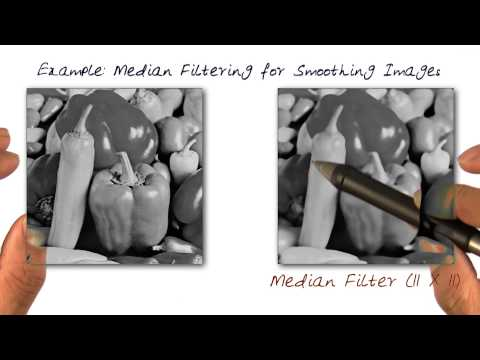

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo("3ELsNs4ERY8",width=640,height=360)

## Part 6: Optional Bonus

&#9989; <font color=red>**DO THIS:**</font> Create an updated version of the Edge detector which includes some improvement. For example:

1. Use a median or Gaussian filter instead of the average filter.
2. Use Non-maximum suppression instead of thresholding.

Learn more about the above options [here](https://web.stanford.edu/class/cs315b/assignment1.html) or pick be creative and try to make something else. 

Make sure the updated code also runs using OpenMP and include it in your Makefile with deliverables.  Include the improved edge detection examples in your report. 

Here is a short video about Median Filters. 

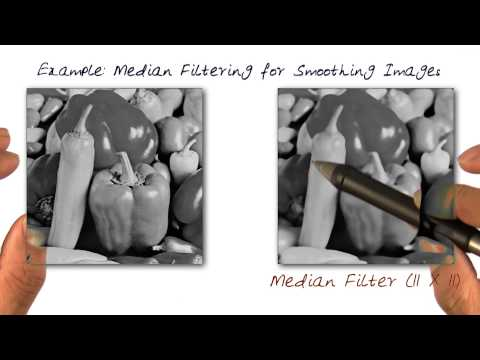

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("3ELsNs4ERY8",width=640,height=360)

----

### Turning in your homework

Now, you need to submit this assignment by uploading your tgz file to the course Desire2Learn web page. Make sure you include your report and source code so the instructor may reproduce your results. 

&#169; Copyright 2019,  Michigan State University Board of Trustees